[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Data Visualizations

## Step 1: Link Notebook to GitHub and Google Drive

In [1]:
import os
import shutil
from google.colab import drive
from google.colab import files

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

# Connect to Google Drive for full dataset
# place should indicate the folder with the csv file and zipped image_data file
# to use sample dataset from repo, change to '/content/BrainAgingComputerVision/data/'
drive.mount('/content/gdrive')
place = '/content/gdrive/My Drive/School/'


Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 254 (delta 20), reused 46 (delta 17), pack-reused 202
Receiving objects: 100% (254/254), 243.73 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Checking out files: 100% (15/15), done.
Mounted at /content/gdrive


In [7]:
import shutil
#move to /content so image manipulation can be done here without using local storage
shutil.copytree(place, '/content/data')

'/content/data'

## Step 2: Import Scripts and Dependencies

In [8]:
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" > /dev/null

from BrainAgingComputerVision.scripts.loaders import RegressionLoaders
from BrainAgingComputerVision.scripts.Rpredicting import get_results

In [1]:
import os
from google.colab import drive
from google.colab import files

#for image processing
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

#for metadata
import pandas as pd

#for data file structure
import splitfolders
import shutil

#for modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

#for metrics
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 2: Data Visualizations

### A) Initial Images

In [12]:
#pull up image metadata
filein = 'content/data/cn_age_df.csv'
data = pd.read_csv(filein)
#data.head()

NameError: ignored

In [13]:
#to reset:
#shutil.rmtree("/content/image_data")

In [14]:
#import files (1267 files)
#note that naming convention includes "test" and "val" but that is not for this project
imgplace = os.path.join(place, 'image_data.zip')
!unzip imgplace > /dev/null

unzip:  cannot find or open imgplace, imgplace.zip or imgplace.ZIP.


In [15]:
#select some for demo purposes and zip
#flist = os.listdir('/content/image_data')
#random.shuffle(flist)
#chunk = flist[:10]
#os.mkdir('sub')

#for f in chunk:
  #imgpl1 = "/content/image_data/" + f
  #imgpl2 = "/content/sub/" + f
  #shutil.copyfile(imgpl1, imgpl2) 

#!zip -r /content/image_data.zip /content/sub

In [16]:
#pick a 3D image to take a look at
image_path = '/content/image_data/0_A_train.npy'
image3D = np.load(image_path)

#show image size (218*182*182)
#print(image3D.size)

#loop to show slices in 5 slice increments
start_sl = 40
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(3, 6)
for m in range(3):
  for w in range(6):
    im = Image.fromarray((image3D[start_sl] * 255).astype(np.uint8))
    im = np.rot90(im)
    axs[m, w].imshow(im, interpolation='nearest', cmap='gray')
    axs[m, w].set_title(str(start_sl))
    axs[m, w].axis('off')
    start_sl += 5

fig.savefig("slices2.png")

NameError: ignored

In [ ]:
#display different ages for reference
#60, 82, 94

images = ['/content/image_data/1488_A_train.npy', '/content/image_data/17_N_test.npy', '/content/image_data/41_A_train.npy']

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 3)
i=0
for m in images:
  #get image
  image_3D = np.load(m)
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  axs[i].imshow(im, interpolation='nearest', cmap='gray')
  #get title
  imgn = m.split("/")[-1]
  imgn = imgn.split(".")[0]
  line = data.loc[data['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[i].set_title("Age: " + str(label))
  axs[i].axis('off')
  i += 1

fig.savefig("3ages.png")


### B) Loader Images

In [9]:
# Visualize a batch of images 
# note: they were compressed sideways, and yes, ages were recorded to a decimal
from BrainAgingComputerVision.scripts.loaders import RegressionLoaders

#this unzips, slices, transforms, and loads files
train_loader, test_loader = RegressionLoaders('/content/data')

images, labels = iter(train_loader).next()
#print(images.shape)

# plot the images in the batch, along with the corresponding labels
# note that images are greyscale, it's just the plot aesthetic that makes them colorful
fig = plt.figure(figsize=(15, 5))
for idx in range(len(train_loader)):
    ax = fig.add_subplot(2, len(train_loader)//2, idx+1, xticks=[], yticks=[])
    im = np.squeeze(images[idx])
    im = np.rot90(im)
    ax.imshow(im, cmap='gray')
    ax.set_title(labels[idx].tolist())

ValueError: ignored

### C) Model Output - Training

In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loss: 234.771037
Loss: 47.355222
Loss: 39.809656
Loss: 36.689202
Loss: 32.891910
Loss: 33.074607
Loss: 32.955210
Loss: 30.390188
Loss: 29.434824
Loss: 26.969457
Loss: 25.733629
Loss: 26.064011
Loss: 24.218996
Loss: 24.575353
Loss: 23.078138
Loss: 22.951943
Loss: 22.610376
Loss: 21.914485
Loss: 20.608701
Loss: 19.872107
Loss: 19.115109
Loss: 20.484734
Loss: 18.598161
Loss: 19.158256
Loss: 18.094039


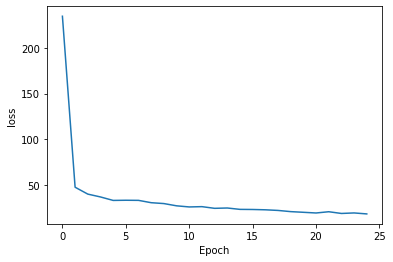

In [ ]:
# Train the model
n_epochs = 25
criterion = nn.MSELoss()
optimizer = optim.SGD(regmodel.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model2(regmodel,criterion,optimizer,train_loader,n_epochs,device)

# Visualize the loss as the network trains
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

### D) Model Output - Prediction

In [ ]:
# Function to get predictions
def get_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        preds = model(images)
        preds = np.squeeze(preds.cpu().numpy())
        preds = np.around(preds, decimals=1)
        labels = labels.cpu().numpy()
    
    return preds, labels

# Function to display a batch of predictions
def visualize_results(preds, labels):

    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        #images
        ax = fig.add_subplot(4, len(preds)//4, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = tf.convert_to_tensor(std) * image + tf.convert_to_tensor(mean)
        image = np.clip(image, 0, 1)
        image = np.squeeze(image)
        image = im = np.rot90(im)
        ax.imshow(image, cmap='gray')
        #titles
        line = str(preds[idx])+" ("+str(labels[idx])+")"
        ax.set_title(line, color=("green" if abs(preds[idx]-labels[idx])<=4 else "red"))
    return

Test set MSE: 21.82000335693708


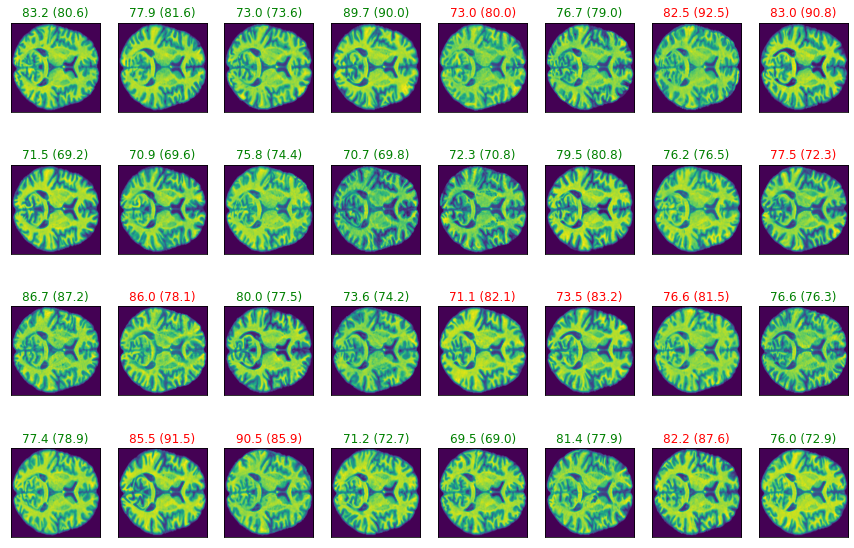

In [ ]:
#test and display results
preds, labels = get_results(regmodel,test_loader,device)
print('Test set MSE: '+ str(mean_squared_error(labels,preds)))

visualize_results(preds, labels)